<a href="https://colab.research.google.com/github/RachelRamirez/FashionMNIST_DataAugmentation/blob/main/9_11_2021_1832_Fashion_mnist_convnet_dealing_with_contrast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Simple (Fashion) MNIST convnet" Architecture with Extremely Limited Data used to Train CNN

**Original Author with MNIST:** [fchollet](https://twitter.com/fchollet)<br>
Date created: 2015/06/19<br>

**Modified to Fashion MNIST** [rachelramirez](https://github.com/RachelRamirez/FashionMNIST_DataAugmentation) 2021/08/25

**Description:** A simple convnet architecture for training on Fashion MNIST, is frozen and then data augmentation techniques are attempted as a Design of Experiment (DOE).

Then data is limited to varying levels of sample sizes  [500, 1000]  to view the effect of data augmentation on increasing model accuracy.

More features are added to original notebook for residual/error analysis such as confusion matrix and data augmentation.

## Google Colab Pro Check Script 

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sun Sep 12 02:08:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
from google.colab import files
from keras.layers import GaussianNoise
from sklearn.metrics import plot_confusion_matrix

print(tf. __version__) 


import pandas as pd
from datetime import datetime
from keras.utils.vis_utils import plot_model

2.6.0


# Experiment

The first part of this experiment is looking at the space for *TrainingSize*, *ValidationSize*, *BatchSize*, and *EpochSize*.  These all likely effect one another (4-way interactions) so a DOE design is used to look at Response Surface Methods.

A: BatchSize (10, 100)

B: Epochs  (15, 50)

C: Training Size (Count)  (100, 1000)

D: Validation (as percentage of Training Size)  (20%, 50%) 

Replicates: 2
Center Points: 1

## Prepare the data

4431872/4422102 [==============================] - 0s 0us/step
AxesSubplot(0.125,0.125;0.775x0.755)
x_train shape: (5000, 28, 28, 1)
5000 train samples
1000 validation samples
54000  test samples saved from the training set


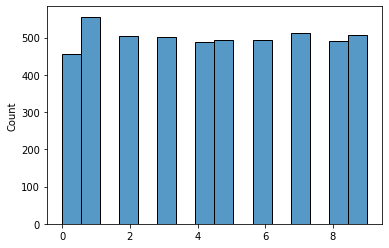

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Until the end of all analysis I don't really want to look at the real test set results
# I'm overwriting them to make sure I don't accidentally use them

x_test = []
y_test = []


# I decide to take a small dataset - 2000 samples of the 60000, and use that to 
# create a TRAIN Set of up to 1000 samples, a VALIDATION Set of up to 1000 samples, and a FAKE-TEST set of the remaining 58000
# After Analyzing the best "Augmentation Effect" I wil apply it to the "REAL" Test DataSet to see if it improved.


# # Validation Set is 1000 --> 500 
x_val = x_train[5000:6000]
y_val = y_train[5000:6000]

# #My FAKE Test Set is 58000
x_test = x_train[6000:60000]
y_test = y_train[6000:60000]


# # Finally I change train dataset to first 1500
x_train = x_train[0:5000]
y_train = y_train[0:5000]

hist= sn.histplot(y_train)
print(hist)
#My holdout Test Set after all the DOE is the original TEST set from dataset


#print("Fashion MNIST has training size up to: ", y_train.shape, ", val set of , ", y_val.shape, " and test set of ", y_test.shape)


# Scale images to the [0, 1] range # put into preprocessing model step
#x_train = x_train.astype("float32") / 255
#x_test = x_test.astype("float32") / 255   
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_val = np.expand_dims(x_val, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validation samples")
print(x_test.shape[0], " test samples saved from the training set")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Try to put in tensor flow shape
x_val = tf.stack(x_val)
y_val = tf.stack(y_val)


# Define Manual Validation Set
valid_set = (x_val, y_val)


Class 2 looks a bit underrepresented, class 7 looks overrepresented in first 1000.  I looked at 1500 and it seemed more balanced

## Image Augmentation Factors 

Augmentation_Building Function to build Data Augmentation Layer in Keras

In [ ]:
def augmentation_building(flip, c, r, n, z, randseed=42, num_classes = 10, input_shape = (28, 28, 1)):  

  if flip == 0:
    flip_layer      = layers.experimental.preprocessing.Rescaling(1./1, input_shape=(input_shape))
  else:
    flip_layer     = layers.experimental.preprocessing.RandomFlip("horizontal", seed = randseed, name = "FlipHorizontal")

  # if r == 0:
  #   rotate_layer    = layers.experimental.preprocessing.Rescaling(1./1, input_shape=(input_shape), name = "RotateOff")
  # else:
  #   rotate_layer   = layers.experimental.preprocessing.RandomRotation(factor = r, seed = randseed, name = "RotateOn")

  if c == 0:
    contrast_layer  = layers.experimental.preprocessing.Rescaling(1./1, input_shape=(input_shape), name = "ContrastOff")
  else:
    contrast_layer = layers.experimental.preprocessing.RandomContrast(factor=c, seed = randseed, name = "ContrastOn") 

  if n == 0:
    noise_layer     = layers.experimental.preprocessing.Rescaling(1./1, input_shape=(input_shape), name = "NoiseOff")
  else:
   noise_layer    = layers.GaussianNoise(n, name = "GaussianNoise")

  if z == 0:
    zoom_layer      = layers.experimental.preprocessing.Rescaling(1./1, input_shape=(input_shape), name = "ZoomOff")
  else:
    zoom_layer     = layers.experimental.preprocessing.RandomZoom(height_factor=z, fill_mode="constant", fill_value=0.0, name="ZoomOn")

  
  data_augmentation = tf.keras.Sequential([
    flip_layer,  
    #rotate_layer,  
    contrast_layer, 
    noise_layer,
    zoom_layer  
  ])
 

  model = keras.Sequential(
  [
      keras.Input(shape=input_shape),
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),
      data_augmentation,   
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      #layers.Dropout(0.5),
      layers.Dense(num_classes, activation="softmax")
  ])
  
  return model


Code to print the training-validation run plots by Accuracy and Loss 


In [ ]:
def print_history(history):
  print(history.history.keys())
  plt.figure(counter+1)

  # plt.subplot(211)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'])
  plt.show()

  # summarize history for loss  
  plt.subplot(212)  
  plt.plot(history.history['loss'])  
  plt.plot(history.history['val_loss'])  
  plt.title('model loss')  
  plt.ylabel('loss')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'validation'], loc='upper left')  
  plt.show() 

# Run the Experiment

In [ ]:
var_trainsize  = 20, 100, 500, 1000, 1500, 2500, 5000 
#var_flip = 0, 1                     # 0 means no flip, 1 means horizontal flip
var_contrast = 0, 0.05, 0.1, 0.15 # 0.001, 0.01, 0.1    # 0 means no contrast (I think) and 1.02 means contrast difference of 0.02  (I think)
# var_rotate = 0, 0.1     #0.025, .05       # 0.5 means rotate between -5 and 5 degrees
var_noise = 0, 0.05, .1  ,0.15       # 0 means no noise, 0.1 means 10% noise
var_zoom = 0, 0.05        #0.05, .1
# randseed = 42 #, 123, 4321


def recordmodel(model, t, currentscore, current_run_variables, score_dictionary):
  if currentscore > score_dictionary[t]['score']:
    modelfilename = str("model_best")  + str(t) + str(".h5")
    model.save_weights(modelfilename) 
    print("                                        \t   * new record accuracy saved")
    score_dictionary[t]['score'] = currentscore
    score_dictionary[t]['record'] = current_run_variables
  

def initialize_variables(t):
  variable_name, variable_value, variable_record = str("best_") + str(t) + str("_run_score"), 0.1, ""
  return variable_name, variable_value, variable_record

# Initialize Score Keeper
score_dictionary = {}
for t in var_trainsize:
    score_dictionary[t] = { 'score': 0.1, 'record': "" }

# Initialize Baseline Score Keepers
basescore = {}
for t in var_trainsize:
    basescore[t] = 0
        


(20, 10)
1 128 100 20 0 0 0 0 0 	 Accuracy:  0.4968  Loss:  3.5980
Baseline Model Saved
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


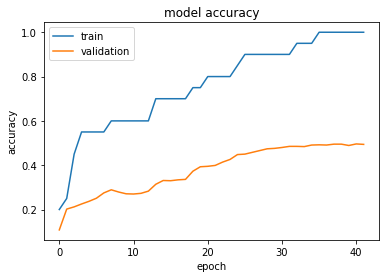

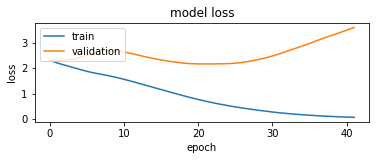

2 128 100 20 0 0 0 0 0.05 	 Accuracy:  0.4840  Loss:  3.9118
                                        	   * new record accuracy saved
3 128 100 20 0 0 0 0.05 0 	 Accuracy:  0.4835  Loss:  3.9563
4 128 100 20 0 0 0 0.05 0.05 	 Accuracy:  0.3350  Loss:  2.3228
5 128 100 20 0 0 0 0.1 0 	 Accuracy:  0.4618  Loss:  3.5774
6 128 100 20 0 0 0 0.1 0.05 	 Accuracy:  0.3279  Loss:  2.3436
7 128 100 20 0 0 0 0.15 0 	 Accuracy:  0.3086  Loss:  2.3355
8 128 100 20 0 0 0 0.15 0.05 	 Accuracy:  0.3727  Loss:  2.5315
9 128 100 20 0 0.05 0 0 0 	 Accuracy:  0.4806  Loss:  3.9399
10 128 100 20 0 0.05 0 0 0.05 	 Accuracy:  0.4724  Loss:  3.9326
11 128 100 20 0 0.05 0 0.05 0 	 Accuracy:  0.4927  Loss:  3.3064
                                        	   * new record accuracy saved
12 128 100 20 0 0.05 0 0.05 0.05 	 Accuracy:  0.3963  Loss:  2.3251
13 128 100 20 0 0.05 0 0.1 0 	 Accuracy:  0.3491  Loss:  2.3349
14 128 100 20 0 0.05 0 0.1 0.05 	 Accuracy:  0.4664  Loss:  3.8832
15 128 100 20 0 0.05 0 0.15 0 	 

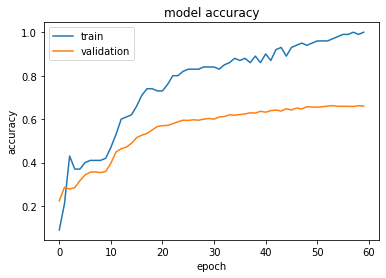

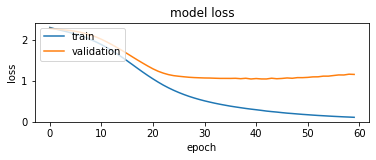

34 128 100 100 0 0 0 0 0.05 	 Accuracy:  0.6665  Loss:  1.1195
                                        	   * new record accuracy saved
35 128 100 100 0 0 0 0.05 0 	 Accuracy:  0.6773  Loss:  1.0779
                                        	   * new record accuracy saved
36 128 100 100 0 0 0 0.05 0.05 	 Accuracy:  0.6674  Loss:  1.1023
37 128 100 100 0 0 0 0.1 0 	 Accuracy:  0.6720  Loss:  1.0679
38 128 100 100 0 0 0 0.1 0.05 	 Accuracy:  0.6918  Loss:  1.0278
                                        	   * new record accuracy saved
39 128 100 100 0 0 0 0.15 0 	 Accuracy:  0.6698  Loss:  1.1458
40 128 100 100 0 0 0 0.15 0.05 	 Accuracy:  0.6626  Loss:  1.1459
41 128 100 100 0 0.05 0 0 0 	 Accuracy:  0.6740  Loss:  1.0523
42 128 100 100 0 0.05 0 0 0.05 	 Accuracy:  0.6905  Loss:  0.9797
43 128 100 100 0 0.05 0 0.05 0 	 Accuracy:  0.6852  Loss:  1.0326
44 128 100 100 0 0.05 0 0.05 0.05 	 Accuracy:  0.6675  Loss:  1.1190
45 128 100 100 0 0.05 0 0.1 0 	 Accuracy:  0.6702  Loss:  1.1022
46 128 

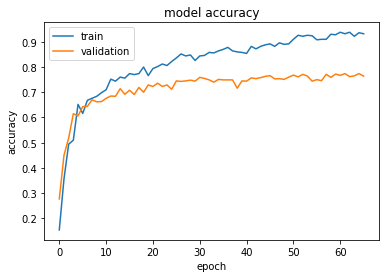

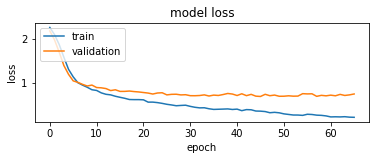

66 128 100 500 0 0 0 0 0.05 	 Accuracy:  0.7806  Loss:  0.6824
                                        	   * new record accuracy saved
67 128 100 500 0 0 0 0.05 0 	 Accuracy:  0.7637  Loss:  0.7391
68 128 100 500 0 0 0 0.05 0.05 	 Accuracy:  0.7828  Loss:  0.6802
                                        	   * new record accuracy saved
69 128 100 500 0 0 0 0.1 0 	 Accuracy:  0.7698  Loss:  0.7006
70 128 100 500 0 0 0 0.1 0.05 	 Accuracy:  0.7742  Loss:  0.6817
71 128 100 500 0 0 0 0.15 0 	 Accuracy:  0.7568  Loss:  0.7413
72 128 100 500 0 0 0 0.15 0.05 	 Accuracy:  0.7703  Loss:  0.6932
73 128 100 500 0 0.05 0 0 0 	 Accuracy:  0.7711  Loss:  0.7467
74 128 100 500 0 0.05 0 0 0.05 	 Accuracy:  0.7757  Loss:  0.7027
75 128 100 500 0 0.05 0 0.05 0 	 Accuracy:  0.7720  Loss:  0.7132
76 128 100 500 0 0.05 0 0.05 0.05 	 Accuracy:  0.7765  Loss:  0.7034
77 128 100 500 0 0.05 0 0.1 0 	 Accuracy:  0.7729  Loss:  0.6904
78 128 100 500 0 0.05 0 0.1 0.05 	 Accuracy:  0.7737  Loss:  0.6670
79 128 100 

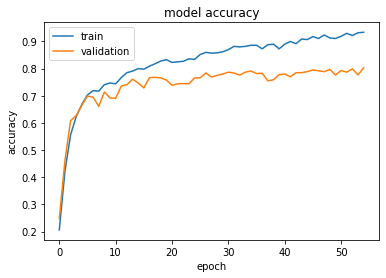

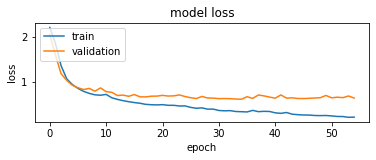

98 128 100 1000 0 0 0 0 0.05 	 Accuracy:  0.7934  Loss:  0.6511
                                        	   * new record accuracy saved
99 128 100 1000 0 0 0 0.05 0 	 Accuracy:  0.8017  Loss:  0.6123
                                        	   * new record accuracy saved
100 128 100 1000 0 0 0 0.05 0.05 	 Accuracy:  0.7869  Loss:  0.6542
101 128 100 1000 0 0 0 0.1 0 	 Accuracy:  0.7736  Loss:  0.7406
102 128 100 1000 0 0 0 0.1 0.05 	 Accuracy:  0.7998  Loss:  0.6273
103 128 100 1000 0 0 0 0.15 0 	 Accuracy:  0.7852  Loss:  0.6381
104 128 100 1000 0 0 0 0.15 0.05 	 Accuracy:  0.8057  Loss:  0.6116
                                        	   * new record accuracy saved
105 128 100 1000 0 0.05 0 0 0 	 Accuracy:  0.7726  Loss:  0.6921
106 128 100 1000 0 0.05 0 0 0.05 	 Accuracy:  0.7694  Loss:  0.6766
107 128 100 1000 0 0.05 0 0.05 0 	 Accuracy:  0.7994  Loss:  0.6051
108 128 100 1000 0 0.05 0 0.05 0.05 	 Accuracy:  0.7842  Loss:  0.6632
109 128 100 1000 0 0.05 0 0.1 0 	 Accuracy:  0.7957 

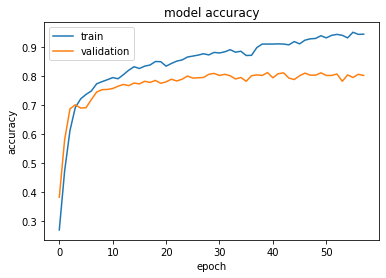

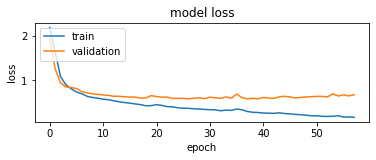

130 128 100 1500 0 0 0 0 0.05 	 Accuracy:  0.8134  Loss:  0.6025
                                        	   * new record accuracy saved
131 128 100 1500 0 0 0 0.05 0 	 Accuracy:  0.8096  Loss:  0.5841
132 128 100 1500 0 0 0 0.05 0.05 	 Accuracy:  0.8132  Loss:  0.5660
133 128 100 1500 0 0 0 0.1 0 	 Accuracy:  0.8043  Loss:  0.5857
134 128 100 1500 0 0 0 0.1 0.05 	 Accuracy:  0.8120  Loss:  0.5799
135 128 100 1500 0 0 0 0.15 0 	 Accuracy:  0.7945  Loss:  0.6056
136 128 100 1500 0 0 0 0.15 0.05 	 Accuracy:  0.8024  Loss:  0.5790
137 128 100 1500 0 0.05 0 0 0 	 Accuracy:  0.8043  Loss:  0.6109
138 128 100 1500 0 0.05 0 0 0.05 	 Accuracy:  0.8028  Loss:  0.6035
139 128 100 1500 0 0.05 0 0.05 0 	 Accuracy:  0.8114  Loss:  0.6215
140 128 100 1500 0 0.05 0 0.05 0.05 	 Accuracy:  0.8131  Loss:  0.5993
141 128 100 1500 0 0.05 0 0.1 0 	 Accuracy:  0.8118  Loss:  0.5792
142 128 100 1500 0 0.05 0 0.1 0.05 	 Accuracy:  0.8017  Loss:  0.6203
143 128 100 1500 0 0.05 0 0.15 0 	 Accuracy:  0.8049  Los

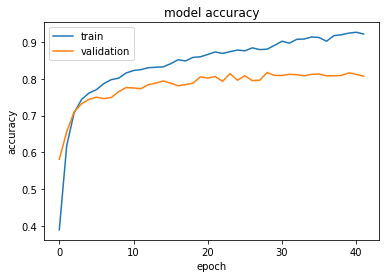

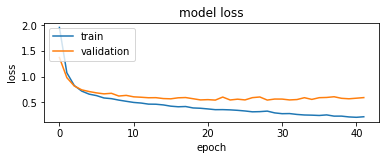

162 128 100 2500 0 0 0 0 0.05 	 Accuracy:  0.8325  Loss:  0.5892
                                        	   * new record accuracy saved
163 128 100 2500 0 0 0 0.05 0 	 Accuracy:  0.8241  Loss:  0.5486
164 128 100 2500 0 0 0 0.05 0.05 	 Accuracy:  0.8304  Loss:  0.5380
165 128 100 2500 0 0 0 0.1 0 	 Accuracy:  0.8174  Loss:  0.5561
166 128 100 2500 0 0 0 0.1 0.05 	 Accuracy:  0.8211  Loss:  0.5491
167 128 100 2500 0 0 0 0.15 0 	 Accuracy:  0.8213  Loss:  0.5267
168 128 100 2500 0 0 0 0.15 0.05 	 Accuracy:  0.8118  Loss:  0.5405
169 128 100 2500 0 0.05 0 0 0 	 Accuracy:  0.8255  Loss:  0.5743
170 128 100 2500 0 0.05 0 0 0.05 	 Accuracy:  0.8207  Loss:  0.5632
171 128 100 2500 0 0.05 0 0.05 0 	 Accuracy:  0.8262  Loss:  0.5401
172 128 100 2500 0 0.05 0 0.05 0.05 	 Accuracy:  0.8257  Loss:  0.5657
173 128 100 2500 0 0.05 0 0.1 0 	 Accuracy:  0.8216  Loss:  0.5565
174 128 100 2500 0 0.05 0 0.1 0.05 	 Accuracy:  0.8063  Loss:  0.5748
175 128 100 2500 0 0.05 0 0.15 0 	 Accuracy:  0.8146  Los

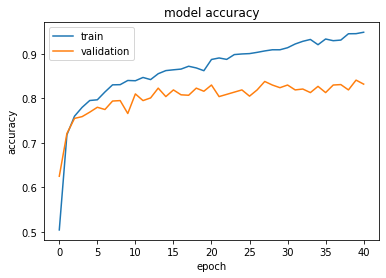

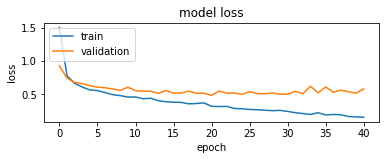

194 128 100 5000 0 0 0 0 0.05 	 Accuracy:  0.8486  Loss:  0.4811
                                        	   * new record accuracy saved
195 128 100 5000 0 0 0 0.05 0 	 Accuracy:  0.8402  Loss:  0.5073
196 128 100 5000 0 0 0 0.05 0.05 	 Accuracy:  0.8323  Loss:  0.5180
197 128 100 5000 0 0 0 0.1 0 	 Accuracy:  0.8353  Loss:  0.4684
198 128 100 5000 0 0 0 0.1 0.05 	 Accuracy:  0.8401  Loss:  0.4822
199 128 100 5000 0 0 0 0.15 0 	 Accuracy:  0.8293  Loss:  0.5031
200 128 100 5000 0 0 0 0.15 0.05 	 Accuracy:  0.8329  Loss:  0.4867
201 128 100 5000 0 0.05 0 0 0 	 Accuracy:  0.8436  Loss:  0.5275
202 128 100 5000 0 0.05 0 0 0.05 	 Accuracy:  0.8416  Loss:  0.5088
203 128 100 5000 0 0.05 0 0.05 0 	 Accuracy:  0.8400  Loss:  0.5385
204 128 100 5000 0 0.05 0 0.05 0.05 	 Accuracy:  0.8429  Loss:  0.4814
205 128 100 5000 0 0.05 0 0.1 0 	 Accuracy:  0.8274  Loss:  0.5424


In [ ]:
scorelist = []
  
counter = 0
#for b in var_batches:
#  for e in var_epochs:
b = 128                    # how would this work for training sets less than this amount?
e = 100
r = 0 # no more rotate
flip = 0 # no more flip

#for randseed in randseeds:  # like the replicates in a test
for t in var_trainsize:

  new_x_train = x_train[0:t]  
  new_y_train = y_train[0:t]
  print(new_y_train.shape)

#  for flip in var_flip:
  for c in var_contrast:
    # for r in var_rotate:
      for n in var_noise:
        for z in var_zoom:
        
          counter+=1
          model = augmentation_building(flip, c, r, n, z, randseed=randseed)
                
          

          callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
          model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
          model.save_weights('model_clear.h5') 
          model.load_weights('model_clear.h5')
          
          
          start_time = datetime.now()
          history = model.fit(new_x_train, new_y_train, batch_size=b, epochs=e, validation_data=valid_set, verbose=0, callbacks=callback)
          #end_time = datetime.now()
          #dur = end_time - start_time

          score = model.evaluate(x_test, y_test, verbose=0)

          scorelist +=  [[counter, e, b,  t,  flip ,c,r,n,z,  score[1], score[0]]]
          print(counter, b, e,  t, flip,c,r,n, z, "\t Accuracy: ", format(score[1], ".4f"), " Loss: ", format(score[0], ".4f"))
          
          current_run_variables = "Flip " + str(flip) +  ", Contrast " + str(c) +  ", Rotate " + str(r) +  ", Noise " + str(n) +  ", Zoom: " + str(z) + "RandSeed" + str(randseed)
        
        
          if flip ==0 and c ==0 and n==0 and z == 0:
            print("Baseline Model Saved")
            modelbaseline = "Baseline" + str(t)  +  ".h5"
            model.save_weights(modelbaseline)
            basescore[t] = score[1]
            print_history(history)
            
          else:  
          #Keep tabs on the best performing 100-run models
            modelname =  "model_" + "best"   + str(t) + ".h5"
            recordmodel(model, t, score[1],  current_run_variables, score_dictionary)
                        
          filename = str(t) + 'T-' + str(flip) + 'F-' + str(c) + "C-" +  str(r) + "R-" +  str(n) + "N-" + str(z) + "Z" + str('.csv')



np.savetxt(filename, scorelist, delimiter=',')
print("File ", filename, " saved at ", start_time)




### Model Summary - model in for-loop (hide)

In [ ]:
 
# tf.keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
# )
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Better Plot Model Option

In [ ]:
!pip install h5py==2.10.0

# Evaluate the trained model on TEST DATA

In [ ]:
LABEL_NAMES = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'AnkleBoots']

modelnames = []
for t in var_trainsize:  
  modelfilename = str("model_best")  + str(t) + str(".h5")
  modelnames = modelnames + [modelfilename]


basenames = []
for t in var_trainsize:  
  modelfilename = str("Baseline")  + str(t) + str(".h5")
  basenames = basenames + [modelfilename]
 
y_test_reshape = np.argmax(y_test, axis=1) 
# Quick Check which model was better (Augmented or Base/Non-Augmented)
for t in var_trainsize:
  if basescore[t] >= score_dictionary[t]['score']:
    print("Base ", t, "has best Accuracy", basescore[t])
  else:
    print("Augmented ", t, "has best Accuracy,", score_dictionary[t]['score'], " compared to ", basescore[t], "difference of \t", (score_dictionary[t]['score']-basescore[t]))


# When Evaluating the Models on the Test/Holdout Data I want to make sure I'm not
#  inadvertently adding a dataaugmentation step, I just want the testdata/holdoutdata to go through the weights.so i respecify the model architecture here
  model = keras.Sequential(
  [
      keras.Input(shape=input_shape),
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),
    #  data_augmentation,   
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      #layers.Dropout(0.5),
      layers.Dense(num_classes, activation="softmax")
  ])


def makeconfusionmatrix(model, modelname, accuracy, tsize, otherinfo = ""):
    model.load_weights(modelname)

    predictions = model.predict(x_test)
    predictions = np.argmax(predictions, axis=1)
    
    confusion_matrix = tf.math.confusion_matrix(y_test_reshape, predictions)  #First Variable is on VERTICAL, second Variable is on X HORIZONTAL
    title = str(modelname) + str(" Accuracy " ) + str(round(accuracy, ndigits=4)) + str(otherinfo)

    f, ax = plt.subplots(figsize=(5, 7), sharey = True)
    sn.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.5,
        fmt="d",
        square=True
        ,cmap=plt.cm.gray_r
        ,cbar=False
        ,xticklabels=LABEL_NAMES
        ,yticklabels=LABEL_NAMES
        #,display_labels=LABEL_NAMES
        ,ax=ax

    )
    plt.title(title)
    ax.set_ylabel('True Category')
    ax.set_xlabel('Predictions')
    plt.show()
  


In my first run, no data augmentation, 100 random samples of the Training Set, using 50% of that as the Validation Set, using a Batch Size of 50 and Epochs = 30, the resulting accuracy of the test-set is Test loss: 0.912209689617157
Test accuracy: 0.6866999864578247

## Confusion Matrix without the Diagonal

In [ ]:
def makeconfusionmatrixminusidentity(model, modelname, accuracy, tsize, otherinfo = ""):
    model.load_weights(modelname)

    predictions = model.predict(x_test)
    predictions = np.argmax(predictions, axis=1)
    
    confusion_matrix = tf.math.confusion_matrix(y_test_reshape, predictions)  #First Variable is on VERTICAL, second Variable is on X HORIZONTAL
    title = str(modelname) + str(" Accuracy " ) + str(round(accuracy, ndigits=4)) + str(otherinfo)


    confusing_part_matrix= np.array(confusion_matrix)-np.identity(confusion_matrix.shape[0])*np.diag(confusion_matrix)
    confusing_part_matrix = tf.convert_to_tensor(confusing_part_matrix)
    title = str(modelname)

    f, ax = plt.subplots(figsize=(9, 7))
    sn.heatmap(
        confusing_part_matrix,
        annot=True,
        linewidths=.5
        ,fmt='.0f'
        ,square=True
        ,cmap=plt.cm.gray_r
        ,cbar=True
        ,vmax=2000
        ,xticklabels=LABEL_NAMES
        ,yticklabels=LABEL_NAMES
        #,display_labels=LABEL_NAMES
        #,ax=ax
    )

  
    plt.title(title)
    plt.show()


    ## find the max value of those remaining numbers
    thisnumber=np.max(confusing_part_matrix)

    # x_thisnumber=np.argmax(confusing_part_matrix,axis=0)
    # y_thisnumber=np.argmax(confusing_part_matrix,axis=1)
    # z_thisnumber=np.argmax(confusing_part_matrix)
    # display(x_thisnumber,y_thisnumber)
    # print("The worst the algorithm did is between " confus)
    z_thisnumber=np.argmax(confusing_part_matrix)
    z_thisnumber
    print("The algorithm misrecognizes ", thisnumber, "  of class " ,  LABEL_NAMES[np.math.floor(z_thisnumber/10)] , " as class ",  LABEL_NAMES[z_thisnumber%10])


    display(sum(sum(confusing_part_matrix)))


for modelname, tsize, basename  in zip(modelnames, var_trainsize, basenames):
  #makeconfusionmatrix(model, modelname, score_dictionary[tsize]['score'], tsize, otherinfo=str(score_dictionary[tsize]['record']))
  #makeconfusionmatrix(model, basename, basescore[tsize], tsize)
  makeconfusionmatrixminusidentity(model, modelname, score_dictionary[tsize]['score'], tsize, otherinfo=str(score_dictionary[tsize]['record']))
  makeconfusionmatrixminusidentity(model, basename, basescore[tsize], tsize)    

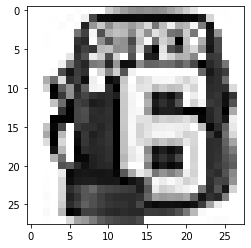

In [ ]:
plt.imshow(x_test[0].reshape((28,28)), cmap=plt.cm.binary)
plt.show()

Evaluate the "Winning Augmentations" for Holdout Data